# Real Estate Regression
### Building a Regression Model to Predict Housing Prices in NY City 
### Jackson Patrick & Trevor Chartier

## Introduction

## Part 1: Data Processing

In [501]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import cKDTree
from geopy.distance import geodesic # may need to run pip install geopy
import pandas.api.types as pd_types

pd.set_option('display.max_rows', 10)

### Read In Dataset

In [502]:

house_df = pd.read_csv("data/NY-House-Dataset.csv")
print(house_df.shape[0], " samples, ", house_df.shape[1], " features")
house_df.head()

4801  samples,  17  features


,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856


### Feature Engineering: Distance to Nearest Subway Station

Before analyzing the dataset and it's features, we would like to add one additional feature based on longitude and latitude -- the distance from the property to the nearest subway station.

In [503]:
subway_df = pd.read_csv("data/MTA_Subway_Stations.csv")
subway_df = subway_df[["GTFS Latitude", "GTFS Longitude"]]
subway_df.rename(columns={"GTFS Latitude": "Latitude", "GTFS Longitude":"Longitude"}, inplace=True)
print(subway_df.shape[0], " Subway Stations Included in NYC Dataset")
subway_df.head()

496  Subway Stations Included in NYC Dataset


,Latitude,Longitude
0,40.725915,-73.994659
1,40.588841,-73.983765
2,40.834255,-73.851222
3,40.680596,-73.955827
4,40.718315,-73.987437


In [504]:
subway_coords = subway_df[['Latitude','Longitude']].values
subway_tree = cKDTree(subway_coords)

subway_distances = []

for _, property in house_df.iterrows():
    property_coord = (property["LATITUDE"], property["LONGITUDE"])
    
    distance, idx = subway_tree.query([property["LATITUDE"], property["LONGITUDE"]])
    
    nearest_subway_coord = subway_coords[idx]
    precise_distance = np.round(geodesic(property_coord, nearest_subway_coord).miles,6)
    subway_distances.append(precise_distance)
    
house_df["NEAREST_SUB_STATION"] = subway_distances

In [505]:
house_df.head()

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,NEAREST_SUB_STATION
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483,0.084535
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991,0.120612
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109,0.605279
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613,0.090788
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856,0.247496


In [506]:
print(len(list(house_df.columns)), "total features after feature engineering")
print("Features: ", list(house_df.columns))

18 total features after feature engineering
Features:  ['BROKERTITLE', 'TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME', 'FORMATTED_ADDRESS', 'LATITUDE', 'LONGITUDE', 'NEAREST_SUB_STATION']


### Analysis of Numerical Features

#### Missing Values

It appears that in this dataset, missing values are filled in with the mean value for the column

We want to identify columns with potentially large numbers of missing values

In [507]:


columns = []
num_mean = []
means = []


def equal_to_mean(colName):
    mean_val = np.mean(house_df[colName])
    is_close = np.isclose(house_df[colName], mean_val, atol=1e-9)
    return is_close

for column in house_df:
    if(pd_types.is_numeric_dtype(house_df[column])):
        columns.append(column)
        total = sum(equal_to_mean(column))
        num_mean.append(total)
        means.append(np.round(np.mean(house_df[column]),2))

df = pd.DataFrame({"Column": columns, "Instances of Mean Value of Column": num_mean, "Mean Value of Column": means})
df

,Column,Instances of Mean Value of Column,Mean Value of Column
0,PRICE,0,2356940.17
1,BEDS,0,3.36
2,BATH,302,2.37
3,PROPERTYSQFT,1621,2184.21
4,LATITUDE,21,40.71
5,LONGITUDE,28,-73.94
6,NEAREST_SUB_STATION,0,0.69


BATH and PROPERTYSQFT have a large number of missing values that will need to be dealt with accordingly. LATITUDE and LONGITUDE have some values that are equal to the mean, but we feel that it is possible these may be actual coordinate values, and there are few enough of them that we have decided to leave them as is.

In [508]:
# Replace imputed values with NaN for ease of various imputation techniques later
house_df.loc[equal_to_mean("BATH"), "BATH"] = np.nan
house_df.loc[equal_to_mean("PROPERTYSQFT"),"PROPERTYSQFT"] = np.nan

#### BEDS

Any values of BEDS that are not a multiple of 0.5 (ie 1, 1.5, 2, etc) :  False


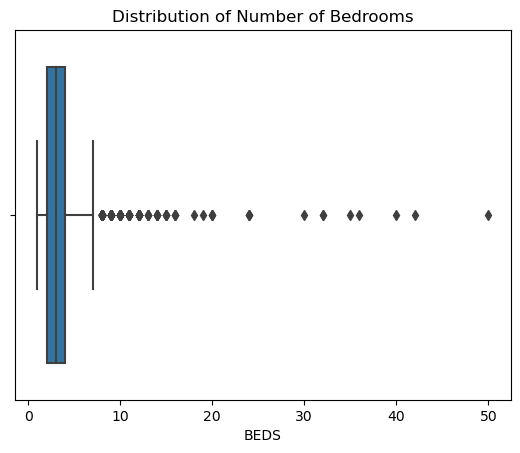

In [509]:
beds = house_df["BEDS"]

sns.boxplot(x=beds)
plt.title("Distribution of Number of Bedrooms");

print("Any values of BEDS that are not a multiple of 0.5 (ie 1, 1.5, 2, etc) : ", (beds % 0.5 != 0).any())

#### BATH

Any values of BATH that are not a multiple of 0.5 (ie 1, 1.5, 2, etc) :  False


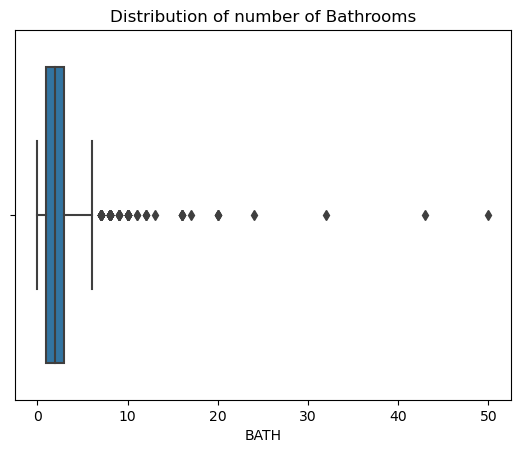

In [510]:
bath = house_df["BATH"]
sns.boxplot(x=bath)
plt.title("Distribution of number of Bathrooms");

print("Any values of BATH that are not a multiple of 0.5 (ie 1, 1.5, 2, etc) : ", (beds % 0.5 != 0).any())

Both the number of bedrooms and number of bathrooms are discrete numerical variables. While most examples have fewer than 5 of each, there are some outliers all the way up to 50. I checked into some of these outlier properties individually and found that they were apartment buildings. 

#### PROPERTYSQFT

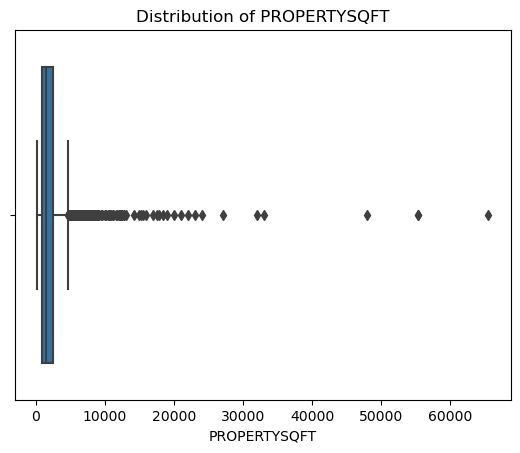

In [511]:
footage = house_df["PROPERTYSQFT"]
sns.boxplot(x=footage)
plt.title("Distribution of PROPERTYSQFT");

We checked into the maximum PROPERTYSQFT value address and it checks out as accurate

#### Label: PRICE

Address of outlier house:  6659-6675 Amboy Rd


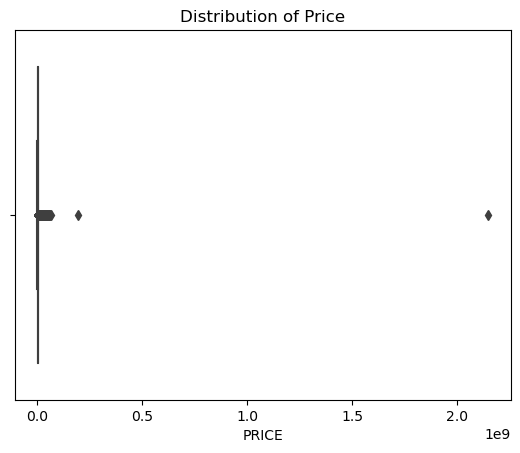

In [512]:
price = house_df["PRICE"]
sns.boxplot(x=price)
plt.title("Distribution of Price")
print("Address of outlier house: ", house_df.iloc[price.idxmax()]["ADDRESS"])

Wow, what an outlier. This outlier price is around 2.14 billion dollars. We investigated the address of this property and found that it was listed in 2023 for 2.49 million dolalrs. This price entry is clearly a mistake, so we will remove it.

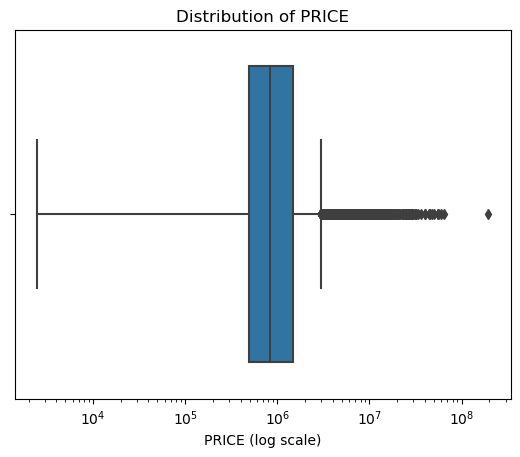

In [513]:
if price.idxmax() == 304:
    house_df.drop(index=price.idxmax(), inplace=True)
    
sns.boxplot(x=house_df["PRICE"])
plt.xscale('log')
plt.xlabel("PRICE (log scale)")
plt.title("Distribution of PRICE");

That looks better. Notice the highest price now, 195 million — the central park tower penthouse suite. Not a data entry error!

#### LATITUDE & LONGITUDE

We have laready used these features to generate the feature of distance to nearest subway station. Another possibility we considered was to use a K-Means clustering algorithm to generate categorical clusters or 'neighborhoods' from the property coordinate points. However, we have already planned to extract the bourough of a property from it's zip-code, which we feel will more effectively capture the clusters. We will still include the raw values of latitude and longitude; however, we hypothesize that feature importance tests will reveal them to be unhelpful to the model.

### Analysis of Categorical Features

In [514]:
# Defining a function to safely drop columns (in case certain cells get run twice)
def drop_column(column_name):
    if column_name in house_df.columns:
        house_df.drop(column_name, axis=1, inplace=True)

In [515]:
# Defining a function to group underrepresented categoreies into an "Other" category

def group_rare_categories(column, cutoff=0.01):
    if "Other" in house_df[column].unique(): 
        pass # Prevent from running the grouping twice
    
    category_proportions = house_df[column].value_counts(normalize=True)
    house_df.loc[house_df[column].map(category_proportions < cutoff), column] = "Other"

Categorical features with very high cardinality, warrant inspection for the following reasons:
* Insufficient number of samples per category
* Increase of computational complexity to encode
* Lead to overfitting if model memorizes categories rather than learning patterns

In [516]:
categorical_columns = ['BROKERTITLE', 'TYPE', 'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME', 'FORMATTED_ADDRESS']
cardinalities = []

for column in categorical_columns:
    cardinalities.append(len(house_df[column].unique()))
    
df = pd.DataFrame({"Categorical Feature" :categorical_columns, "Cardinality":cardinalities})
df

,Categorical Feature,Cardinality
0,BROKERTITLE,1035
1,TYPE,13
2,ADDRESS,4582
3,STATE,307
4,MAIN_ADDRESS,4582
...,...,...
6,LOCALITY,11
7,SUBLOCALITY,21
8,STREET_NAME,174
9,LONG_NAME,2731


#### BROKERTITLE

In [517]:
broker_counts = house_df["BROKERTITLE"].value_counts()
threshold = len(house_df) * .01 # Determine a "rare" category to be one with fewer than 1% of total examples
print(len(broker_counts[broker_counts > threshold]), "brokers have at least 1% of total samples")
print("Together, these 10 brokers represent ", broker_counts[broker_counts > threshold].sum(), "samples")
print("\nNumber of properties brokered by various brokers: ")
broker_counts.head()

10 brokers have at least 1% of total samples
Together, these 10 brokers represent  1124 samples

Number of properties brokered by various brokers: 


Brokered by COMPASS                              456
Brokered by Douglas Elliman - 575 Madison Ave    110
Brokered by Brown Harris Stevens                  93
Brokered by Corcoran East Side                    91
Brokered by RE MAX Edge                           79
Name: BROKERTITLE, dtype: int64

There are some brokers with a significant number of samples in the dataset. Specifically, 10 brokers have at least 49 representative samples (1% of total). However, the vast majority of BROKERTITLE categories are rare (ie contain less than 1%) and many contain just a couple examples.

In [518]:
property_broker_counts = house_df["BROKERTITLE"].map(broker_counts)

print("Pearson Correlation: ", np.round(property_broker_counts.corr(house_df["PRICE"], method="pearson"),3))
print("Spearmen Correlation: ", np.round(property_broker_counts.corr(house_df["PRICE"], method="spearman"),3))
print("Kendall Correlation: ", np.round(property_broker_counts.corr(house_df["PRICE"], method="kendall"),3))


Pearson Correlation:  0.096
Spearmen Correlation:  0.234
Kendall Correlation:  0.16


The list property_broker_counts is a frequency encoding of BROKERTITLE. The low pearson correlation coefficient suggests no linear relationship between property_broker_counts and PRICE. However, the moderate values of Spearmen and Kendall correlation suggest some monotonic relationship between the number of properties sold by a broker and the PRICE. As one increases, so too does the other, but not at a constant rate. There seems to be some signal contained within the BROKERTITLE variable.

The high cardinality of BROKERTITLE, the large number of rare categories, and the seemingly ordinal relationship have led us to a few possibilities:
1. Group categories with fewer than 1% of representative samples into an "other" category
2. Use a frequency encoding
3. Encode BROKERTITLE into a BROKER_ACTIVITY feature containing the categories low activity, medium activity, and high activity

Option 1 will result in 11 total categories and rougly 3/4 of the data belonging to the "other" category. 
Option 2 will also result in a skewed distribution

Our judgement suggests that option 3 may be the most balanced solution that simplifies the feature's cardinality while maintaining the ordinal relationship, and limits highly skewed distributions. We did experiment with using option 1 by itself and in conjunction with option 3, but we ultimately found that using option 3 alone produced the best performing models.

In [519]:

if "BROKER_ACTIVITY" not in house_df.columns:
    broker_counts[broker_counts < 7] = 0 # Brokers with fewer than 7 examples are considered low
    broker_counts[(broker_counts <= 25) & (broker_counts >= 7)] = 1 # Brokers with between 7 and 25 are considered medium
    broker_counts[(broker_counts > 25) & (broker_counts <= 50)] = 2 # Brokers between 25 and 50 are considered high
    broker_counts[(broker_counts > 50)] = 3 # Brokers over 50 considered very high
    
    house_df["BROKER_ACTIVITY"] = house_df["BROKERTITLE"].map(broker_counts)
    drop_column("BROKERTITLE")

# Output distribution of categories
df = pd.DataFrame(house_df["BROKER_ACTIVITY"].value_counts())
df.reset_index(inplace=True)
df.columns = ["BROKER_ACTIVITY", "Number of Samples"]
df = df.sort_values(by="BROKER_ACTIVITY")
df["Activity Level"] = ['Low', 'Medium', 'High', "Very High"]
df = df[["Activity Level", "BROKER_ACTIVITY", "Number of Samples"]]
df

,Activity Level,BROKER_ACTIVITY,Number of Samples
0,Low,0,1707
1,Medium,1,1217
3,High,2,752
2,Very High,3,1124


Admittedly, the cutoff points of 7, 25, and 50 were somewhat arbitrary; however, we did try various values before finding ones that we were satisfied with the resulting class distribution. 

An alternative approach would have been to use values that perfectly divided the classes (or as close as possible), but we felt this was unecessary.

Additionaly, it is worth noting that we had orignally used 3 categories, with cutoff points of 7 and 25. However, including a 4th category for Very High activity (over 50 properties) seemed to improve model performance.

#### Type

In [520]:
type = house_df["TYPE"]
type_values = np.round(type.value_counts(normalize=True),3)
df = type_values.reset_index()
df.columns= ["TYPE", "Proportion of Samples"]
df

,TYPE,Proportion of Samples
0,Co-op for sale,0.302
1,House for sale,0.211
2,Condo for sale,0.186
3,Multi-family home for sale,0.151
4,Townhouse for sale,0.062
...,...,...
8,For sale,0.004
9,Foreclosure,0.003
10,Condop for sale,0.001
11,Coming Soon,0.000


For TYPE, the cardinality isn't too high; however, there are some categories with an insuficcient number of samples. To handle this feature, I will group categories under the 1% threshold into a singular "other" category.

In [521]:
group_rare_categories(column="TYPE", cutoff=.01)

#### ADDRESS, MAIN_ADDRESS, FORMATTED_ADDRESS

Not only is there high multicolinearity between these features, but they are nearly unique to each observation, meaning there is nearly no predicitve power within these features. 

They may conatin useful information such as zip code or street name, but this information is also contained within other columns (which we will discuss later)

For these reasons, we have decided to drop these features.

In [522]:
drop_column("ADDRESS")
drop_column("MAIN_ADDRESS")
drop_column("FORMATTED_ADDRESS")

#### LONG_NAME

In [523]:
print(len(house_df["LONG_NAME"].unique()), " unique categories for LONG_NAME")

print("Number of Categories in LONG_NAME With at Least 1% of representative samples: ",(house_df["LONG_NAME"].value_counts(normalize=True) > .01).sum())

2731  unique categories for LONG_NAME
Number of Categories in LONG_NAME With at Least 1% of representative samples:  0


LONG_NAME has incredibly high cardinality. No categories are represented by at least 1% of the samples in the dataset. It will be dropped.

In [524]:
drop_column("LONG_NAME")

#### SUBLOCALITY

In [525]:
print("Unique Categories in SUBLOCALITY: ", list(house_df["SUBLOCALITY"].unique()))
counts = house_df["SUBLOCALITY"].value_counts().head(20)
print("\nValue Counts for the Top 20 Categories: ")
df = counts.reset_index()
df.columns= ["SUBLOCALITY", "Number of Samples"]
df

Unique Categories in SUBLOCALITY:  ['Manhattan', 'New York County', 'Richmond County', 'Kings County', 'New York', 'East Bronx', 'Brooklyn', 'The Bronx', 'Queens', 'Staten Island', 'Queens County', 'Bronx County', 'Coney Island', 'Brooklyn Heights', 'Jackson Heights', 'Riverdale', 'Rego Park', 'Fort Hamilton', 'Flushing', 'Dumbo', 'Snyder Avenue']

Value Counts for the Top 20 Categories: 


,SUBLOCALITY,Number of Samples
0,New York,1016
1,Kings County,727
2,Queens County,684
3,Queens,555
4,Richmond County,479
...,...,...
15,Brooklyn Heights,1
16,Jackson Heights,1
17,Rego Park,1
18,Fort Hamilton,1


SUBLOCALITY contains information on the boroughs and neighborhoods in NYC. I like this concept, especially the bouroughs, as this could capture some information about the socioeconomic status of the broad region of a property. However, after reviewing LONG_NAME and STATE_NAME I am concerned about the overall reliability of this feature and the mix of neighborhoods and bouroughs. 

I will drop this feature and instead use feature engineering from the zip-code to create a feature for bourough. 

In [526]:
drop_column("SUBLOCALITY")

#### LOCALITY

In [527]:
print("Unique Categories in LOCALITY: ", list(house_df["LOCALITY"].unique()))


Unique Categories in LOCALITY:  ['New York', 'New York County', 'The Bronx', 'Kings County', 'Bronx County', 'Queens County', 'Richmond County', 'United States', 'Brooklyn', 'Queens', 'Flatbush']


Dropping this column for the same reason as SUBLOCALITY

In [528]:
drop_column("LOCALITY")

#### STATE

In [529]:
state = house_df["STATE"]
print(len(state.unique()), " unique categories for STATE")
print("\nFirst Five State Entries: ")
state.head()

307  unique categories for STATE

First Five State Entries: 


0         New York, NY 10022
1         New York, NY 10019
2    Staten Island, NY 10312
3        Manhattan, NY 10022
4         New York, NY 10065
Name: STATE, dtype: object

STATE is a feature with high cardinality. It also appears that the end of each STATE string is the zip code. Let's focus on this part for now...

In [530]:
# Replace STATE Feature with extracted ZIP_CODE feature
house_df["zip"] = state.apply(lambda x: x.split()[-1])
print(len(house_df["zip"].unique()), "uniqe zip-code categories")

zip_values = house_df["zip"].value_counts(normalize=True)
print((zip_values > .01).sum(), " zip-codes have at least 1% of total samples")

178 uniqe zip-code categories
30  zip-codes have at least 1% of total samples


The zip-code may contain valuable information regarding price. First, we will map the zip-codes into the bouroughs of NYC they belong in.

In [531]:
# Load in a mapping from zip code to bourough
zip_borough_df = pd.read_csv("data/zip_borough.csv")
zip_borough_df["zip"] = zip_borough_df["zip"].astype(str)
zip_borough_df.head(3)

,zip,borough
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan


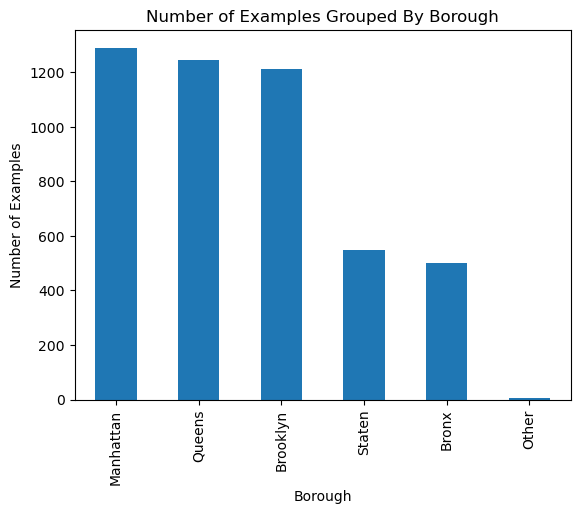

In [532]:
if 'BOROUGH' not in house_df.columns:
    house_df = house_df.merge(zip_borough_df, on="zip", how='left')
    house_df['BOROUGH'] = house_df['borough'].fillna('Other')
    drop_column('borough')
    drop_column("STATE")
    house_df = house_df.rename(columns={'zip':'ZIP'})
    
# Plot the resulting distribution   
borough_counts = house_df['BOROUGH'].value_counts()
borough_counts.plot(kind='bar')
plt.xlabel('Borough')
plt.ylabel("Number of Examples")
plt.title("Number of Examples Grouped By Borough");

After some experimentation, we found that Zip Code is also a valuable feature to include. However, to overcome the sparsity, we will group zip codes that have fewer than 1% of representative samples into an "other" category, similair to how we handled the TYPE feature.

In [533]:
group_rare_categories(column="ZIP", cutoff=.01)

#### STREET_NAME

In [534]:
print(len(house_df["STREET_NAME"].unique()), " unique categories for STREET_NAME")
print("\n10 Most Common Categories for STREET_NAME: ")
house_df["STREET_NAME"].value_counts(normalize=True).head(10)

174  unique categories for STREET_NAME

10 Most Common Categories for STREET_NAME: 


Manhattan          0.203958
Brooklyn           0.151458
Queens             0.142500
Staten Island      0.099792
The Bronx          0.064583
New York           0.059375
Flushing           0.028958
Forest Hills       0.012917
Bayside            0.008750
Jackson Heights    0.008750
Name: STREET_NAME, dtype: float64

It appears that STREET_NAME was extracted as the second token in the formatted address. Unfortunately, this seems to be an unreliable method to extract the street name and it instead appears to be a mix of street name, county, and state information.

At first, I thought this feature would be useless, but I decided to experiment with including it as a categorical feature and found that it was mostly redundant to the BOROUGH feature; however, the category "New York" was ranked third in feature importance on a preliminary random forest model. I will transform this column into a binary indicator for "New York".

In [535]:
house_df["NEW_YORK_INDICATOR"] = (house_df["STREET_NAME"] == "New York").astype(int)
drop_column("STREET_NAME")

#### ADMINISTRATIVE_AREA_LEVEL_2

In [536]:
house_df["ADMINISTRATIVE_AREA_LEVEL_2"].unique()

array(['New York County', 'United States', 'New York', 'Bronx County',
       '11214', '10301', '10309', '10303', '11234', '11414', '10310',
       '10003', '11417', '10304', 'Kings County', '10463',
       'Queens County', '10017', '10306', '10471', '11229', '10312',
       '11412', '10465', 'Brooklyn', '10002', '10466', '11237', '11218'],
      dtype=object)

This feature appears to be a mixture of zip-code, county, state, and country values. It appears to be unreliable and contains information already captured elsewhere, such as bourough. We will drop this feature.

In [537]:
drop_column("ADMINISTRATIVE_AREA_LEVEL_2")

In [538]:
print(len(list(house_df.columns)), "total features after data processing")
print(len(house_df), "total examples")

house_df.head(10)

12 total features after data processing
4800 total examples


,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,NEAREST_SUB_STATION,BROKER_ACTIVITY,ZIP,BOROUGH,NEW_YORK_INDICATOR
0,Condo for sale,315000,2,2.0,1400.0,40.761255,-73.974483,0.084535,2,10022,Manhattan,0
1,Condo for sale,195000000,7,10.0,17545.0,40.766393,-73.980991,0.120612,3,10019,Manhattan,1
2,House for sale,260000,4,2.0,2015.0,40.541805,-74.196109,0.605279,2,10312,Staten,0
3,Condo for sale,69000,3,1.0,445.0,40.761398,-73.974613,0.090788,3,10022,Manhattan,1
4,Townhouse for sale,55000000,7,NaN,14175.0,40.767224,-73.969856,0.247496,3,10065,Manhattan,1
5,House for sale,690000,5,2.0,4004.0,40.674363,-73.958725,0.064344,2,Other,Brooklyn,0
6,Condo for sale,899500,2,2.0,NaN,40.809448,-73.946777,0.134839,3,Other,Manhattan,0
7,House for sale,16800000,8,16.0,33000.0,40.595002,-74.106424,0.803902,0,10304,Staten,0
8,Co-op for sale,265000,1,1.0,750.0,40.821586,-73.874089,0.548021,0,Other,Bronx,0
9,Co-op for sale,440000,2,1.0,978.0,40.615738,-73.969694,0.240321,0,Other,Brooklyn,0


### Encoding Categorical Variables

The ordinal categorical variables, BOROUGH, ZIP, and TYPE need to be encoded

In [540]:
categorical_columns = ["TYPE", "BOROUGH","ZIP"]

if categorical_columns[0] in house_df.columns: # Prevent code from running twice
    house_df = pd.get_dummies(house_df, columns=categorical_columns)

    # Use k-1 encoding to prevent multicolinearity
    for column in categorical_columns:
        drop_column(column+"_Other")

print(house_df.shape[1], "total features after encoding.")

52 total features after encoding.


# Part 2: Model Training

In [541]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

### TODO : Baseline Models

### Random-Forest Regression

Standardizing features is not necessary for this tree-based model. RF regression does not natively support non-numeric categorical variables, so I will perform One Hot Encoding on my nominal categorical features (TYPE, BOROUGH). RF Regression also does not natively support NaN values, so we will try various imputation methods treating the method like a hyperparameter.

In [542]:
X = house_df.drop("PRICE", axis=1)
y = house_df["PRICE"]

imputer = SimpleImputer(strategy='median')
X["PROPERTYSQFT"] = imputer.fit_transform(X[["PROPERTYSQFT"]])
X["BATH"] = imputer.fit_transform(X[["BATH"]])

X.head(5)

,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,NEAREST_SUB_STATION,BROKER_ACTIVITY,NEW_YORK_INDICATOR,TYPE_Co-op for sale,TYPE_Condo for sale,...,ZIP_11201,ZIP_11209,ZIP_11215,ZIP_11229,ZIP_11234,ZIP_11235,ZIP_11360,ZIP_11372,ZIP_11374,ZIP_11375
0,2,2.0,1400.0,40.761255,-73.974483,0.084535,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,7,10.0,17545.0,40.766393,-73.980991,0.120612,3,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4,2.0,2015.0,40.541805,-74.196109,0.605279,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1.0,445.0,40.761398,-73.974613,0.090788,3,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,7,2.0,14175.0,40.767224,-73.969856,0.247496,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [543]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [551]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)



In [552]:
mae

649690.8452691798

In [546]:
importances = rf.feature_importances_
feature_names = X.columns

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

pd.set_option('display.max_rows', None)
feature_importance

,Feature,Importance
2,PROPERTYSQFT,0.282740
25,ZIP_10019,0.139938
7,NEW_YORK_INDICATOR,0.102237
9,TYPE_Condo for sale,0.093595
0,BEDS,0.065577
18,BOROUGH_Manhattan,0.061578
4,LONGITUDE,0.054349
1,BATH,0.047233
3,LATITUDE,0.042770
5,NEAREST_SUB_STATION,0.039622


In [ ]:
# X = house_df.drop("PRICE", axis=1)
# y = house_df["PRICE"]

# processor = ColumnTransformer(
#     transformers=[
#         ('imputer', SimpleImputer(strategy='median'), ["PROPERTYSQFT", "BATH"])
#     ],
#     remainder='passthrough'
# )

# pipeline = Pipeline([
#     ('processor', processor),
#     ('model', RandomForestRegressor(n_estimators=100))
# ])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# param_grid = {
#     'model__max_depth': [None, 10, 20],            
#     'model__min_samples_split': [2, 5, 10],     
#     'model__min_samples_leaf': [1, 2, 4],         
#     'model__max_features': ['sqrt', 'log2', None] 
# }

# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
#                            cv=2, scoring='neg_mean_absolute_error', n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Score (Negative MAE):", grid_search.best_score_)

# best_pipeline = grid_search.best_estimator_
# y_pred = best_pipeline.predict(X_test)
# mae = mean_absolute_error(y_test, y_pred)